In [84]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import pickle
import sys, os
import time
main_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(1, main_path)
import GD
from SPN import SPN
import utils
from viz import plot_UAV_FLPO, plot_UAV_FLPO_3D
from pathlib import Path
from Anneal import anneal
np.random.seed(42)


# Load a Scenario

In [85]:
seed=3
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
scene_path = "benchmark_data/N10_M4_ends2_seed3"
print("Running on: " , device)

with open(scene_path, 'rb') as file:
    data = pickle.load(file)
START_locs = data["START_locs"]
F_base = data["F_base"]
END_locs = data["END_locs"]
num_drones = START_locs.shape[0]
num_facilities = F_base.shape[-2]
dim_ = F_base.shape[-1]
num_distinct_ends = len(torch.unique(END_locs, dim=0))
print(f"num_drones = {num_drones}\t num_facilities = {num_facilities}\t dim = {dim_}\t num_distinct_ends = {num_distinct_ends}")
assert(F_base.requires_grad == True)

s = START_locs.cpu().numpy().reshape(-1,1,2)
e = END_locs.cpu().numpy().reshape(-1,1,2)
Y_init = F_base.detach().cpu().numpy()

n_algo_iters = 10
discardPSO = True
discardACO = True

# plot_UAV_FLPO(START_locs, END_locs, F_base, (12,10))
# # plot_UAV_FLPO_3D(START_locs, END_locs, F_base)

Running on:  cpu
num_drones = 10	 num_facilities = 4	 dim = 2	 num_distinct_ends = 2


In [86]:
# create a dataset of nodes and agents
# num_nodes = 10
# num_agents = 30
# dim = 2  # dimension of the space
# def generate_example(dim=2, num_nodes=30, num_agents=20):
#     nodes = 0.5 + 0.01 * np.random.randn(1, num_nodes, dim)  # centered at [0.5, 0.5] with small perturbation
#     s = np.random.rand(num_agents,1, dim)
#     e = np.random.rand(num_agents,1, dim)
#     return s, e, nodes
# s, e, Y_init = generate_example(num_nodes=num_facilities, num_agents=num_drones, dim=dim)

Text(0.5, 1.0, 'Nodes and Agents in 2D Space')

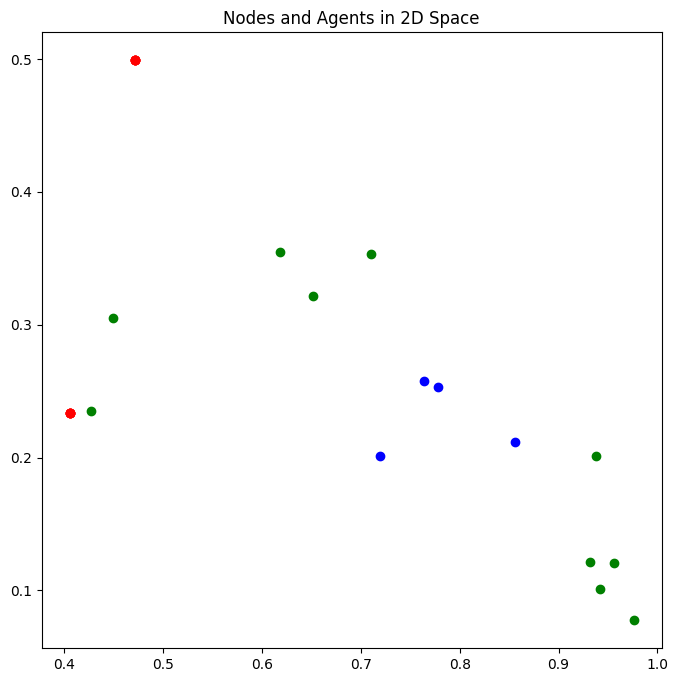

In [87]:

# plot the nodes and agents
plt.figure(figsize=(8, 8))
plt.scatter(Y_init[0, :, 0], Y_init[0, :, 1], c='blue', label='Nodes')
plt.scatter(s[:, 0, 0], s[:, 0, 1], c='green', label='Start Points')
plt.scatter(e[:, 0, 0], e[:, 0, 1], c='red', label='End Points')
plt.title('Nodes and Agents in 2D Space')

# PSO

In [88]:
# run the PSO algorithm
from PSO import pso, pso_plot, pso_print

if discardPSO:
    t_pso_arr = None
    c_pso_arr = None
    t_pso_min = None
    c_pso_min = None
else:
    num_particles = 500
    num_iters = 300
    w = 0.9 # inertia weight
    c1 = 0.5  # cognitive (individual) weight
    c2 =1.5  # social (group) weight
    t_pso_arr = []
    c_pso_arr = []
    for i in range(n_algo_iters):
        y_final, eta_final, global_best_cost, elapsed_time = pso(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=Y_init,
            verbose=True,
            w=w,
            c1=c1,
            c2=c2,
            num_particles=num_particles,
            num_iters=num_iters,
        )
        t_pso_arr.append(elapsed_time)
        c_pso_arr.append(global_best_cost)

    t_pso_min = np.min(t_pso_arr)
    c_pso_min = np.min(c_pso_arr)
    pso_print(y_final, eta_final, global_best_cost, elapsed_time, s, e)
    pso_plot(y_final, eta_final, s, e)

In [89]:
t_pso_min, c_pso_min

(None, None)

# Genetic Algorithm

GA Solution:
Best Cost: 3.8487
Elapsed Time: 0.05s
Node positions (y):
  Node 0: [0.62073538 0.22571063]
  Node 1: [0.76808324 0.18977738]
  Node 2: [0.64161273 0.40992949]
  Node 3: [0.82437111 0.07158196]
Agent 0 path:
Node 0  -> Node 2  -> Node 1  -> Node 3  -> End
Agent 1 path:
Node 0  -> Node 2  -> Node 3  -> Node 3  -> End
Agent 2 path:
Node 1  -> Node 3  -> Node 1  -> Node 3  -> End
Agent 3 path:
Node 0  -> Node 3  -> Node 3  -> Node 0  -> End
Agent 4 path:
Node 2  -> Node 2  -> Node 2  -> Node 1  -> End
Agent 5 path:
Node 0  -> Node 3  -> Node 0  -> Node 1  -> End
Agent 6 path:
Node 1  -> Node 2  -> Node 3  -> Node 1  -> End
Agent 7 path:
Node 1  -> Node 2  -> Node 0  -> Node 0  -> End
Agent 8 path:
Node 0  -> Node 0  -> Node 2  -> Node 1  -> End
Agent 9 path:
Node 3  -> Node 2  -> Node 3  -> Node 1  -> End


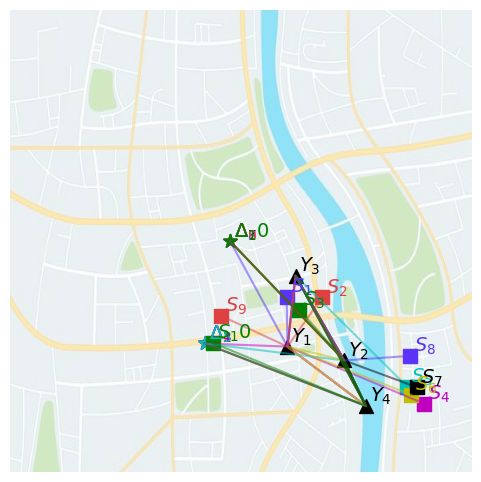

In [90]:
from GA import ga, ga_plot, ga_print
t_ga_arr = []
c_ga_arr = []
for i in range(n_algo_iters):
    best_y, best_eta, best_cost, elapsed_time = ga(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=None,
            verbose=False,
            pop_size=100,
            generations=8000,
            mutation_rate=0.3,        
        )
    t_ga_arr.append(elapsed_time)
    c_ga_arr.append(best_cost)
t_ga_min = np.min(t_ga_arr)
c_ga_min = np.min(c_ga_arr)
ga_print(s, e, best_y, best_eta, best_cost, elapsed_time)
ga_plot(s, e, best_y, best_eta)

In [91]:
t_ga_min, c_ga_min

(0.04567289352416992, 3.1042573361437102)

# SA

Final solution:
Node positions (y):
  Node 0: [0.7639706  0.25771856]
  Node 1: [0.77784544 0.25317818]
  Node 2: [0.8554976  0.21146621]
  Node 3: [0.7192497  0.20075409]
Agent paths (eta):
  Agent 0: Node 3 -> Node 1 -> Node 1 -> Node 3 -> End
  Agent 1: Node 3 -> Node 0 -> Node 1 -> Node 1 -> End
  Agent 2: Node 1 -> Node 3 -> Node 2 -> Node 0 -> End
  Agent 3: Node 3 -> Node 1 -> Node 0 -> Node 2 -> End
  Agent 4: Node 2 -> Node 1 -> Node 0 -> Node 1 -> End
  Agent 5: Node 3 -> Node 0 -> Node 2 -> Node 1 -> End
  Agent 6: Node 0 -> Node 0 -> Node 3 -> Node 1 -> End
  Agent 7: Node 1 -> Node 3 -> Node 1 -> Node 3 -> End
  Agent 8: Node 3 -> Node 0 -> Node 3 -> Node 3 -> End
  Agent 9: Node 1 -> Node 3 -> Node 0 -> Node 1 -> End
Start positions (s):
  Agent 0: [0.6186674  0.35476613]
  Agent 1: [0.7104527 0.3535505]
  Agent 2: [0.6516481 0.3217567]
  Agent 3: [0.9758923  0.07744691]
  Agent 4: [0.9319452  0.12129531]
  Agent 5: [0.94245046 0.10063247]
  Agent 6: [0.9565085  0.1204334

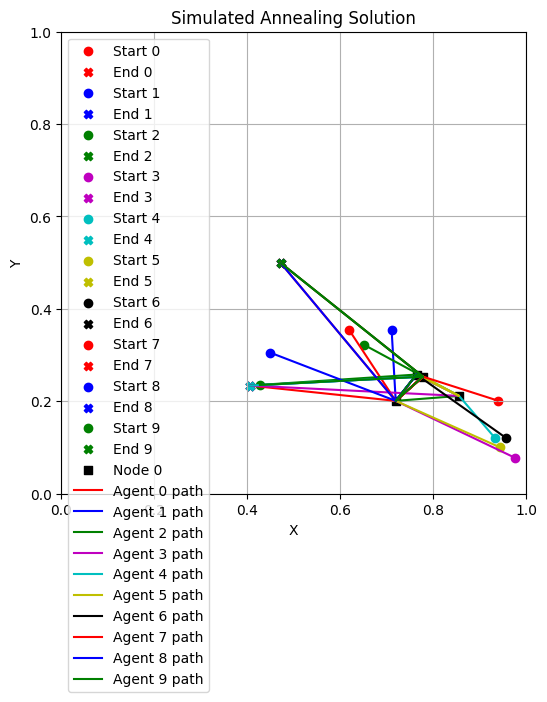

In [92]:
from SA import sa, plot_sa, print_sa
t_sa_arr = []
c_sa_arr = []
for i in range(n_algo_iters):
    best_y, best_eta, best_cost, elapsed_time = sa(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=Y_init,
            YMIN=0,
            YMAX=1.0,
            iters=20000,
            verbose=False,
        )
    t_sa_arr.append(elapsed_time)
    c_sa_arr.append(best_cost)
t_sa_min = np.min(t_sa_arr)
c_sa_min = np.min(c_sa_arr)
print_sa(s, e, best_y, best_eta)
plot_sa(s, e, best_y, best_eta)

In [93]:
t_sa_min, c_sa_min

(0.000701904296875, 2.0986566257633967)

# CEM

CEM Solution:
Best Cost: 8.6053
Elapsed Time: 0.11 seconds
Node positions (y):
[[0.78661477 0.55010578]
 [0.95896485 0.24263557]
 [0.97645069 0.06446797]
 [0.68729346 0.23635555]]
Agent paths (indices):
Agent 0: Node 2 -> End -> Node 0 -> Node 1 -> End
Agent 1: Node 2 -> Node 2 -> End -> Node 1 -> End
Agent 2: Node 2 -> End -> End -> End -> End
Agent 3: Node 1 -> Node 0 -> Node 2 -> Node 1 -> End
Agent 4: Node 2 -> Node 3 -> Node 1 -> Node 0 -> End
Agent 5: Node 3 -> End -> Node 1 -> End -> End
Agent 6: End -> Node 0 -> Node 3 -> Node 1 -> End
Agent 7: Node 3 -> Node 0 -> Node 0 -> Node 3 -> End
Agent 8: Node 0 -> Node 2 -> End -> Node 2 -> End
Agent 9: Node 0 -> Node 0 -> Node 0 -> Node 3 -> End


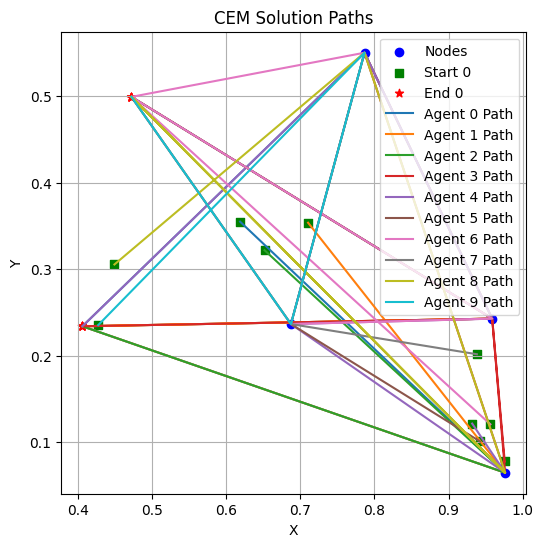

In [94]:
from CEM import cem, plot_cem, print_cem

t_cem_arr = []
c_cem_arr = []
for i in range(n_algo_iters):
    best_y, best_eta, best_cost, elapsed_time = cem(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=Y_init,
            YMIN=0,
            YMAX=1.0,
            n_iter=2000,
            pop_size=100,
            elite_frac=0.2,
            verbose=False,
        )
    t_cem_arr.append(elapsed_time)
    c_cem_arr.append(best_cost)
t_cem_min = np.min(t_cem_arr)
c_cem_min = np.min(c_cem_arr)
print_cem(s, e, best_y, best_eta, best_cost, elapsed_time)
plot_cem(s, e, best_y, best_eta)

In [95]:
t_cem_min, c_cem_min

(0.11299729347229004, 4.466182351236327)

# ACO

In [96]:
from ACO import aco, plot_aco, print_aco

if discardACO:
    t_aco_arr = None
    c_aco_arr = None
    t_aco_min = None
    c_aco_min = None
else:
    t_aco_arr = []
    c_aco_arr = []
    for i in range(n_algo_iters):
        best_y, best_eta, best_cost, elapsed_time = aco(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=Y_init,
            YMIN=0.0,
            YMAX=1.0,
            num_iters=200,
            num_ants=100,
            alpha=1.0,
            beta=1.0,
            rho=0.5,
            Q=1.0,
            verbose=True,
        )
        t_aco_arr.append(elapsed_time)
        c_aco_arr.append(best_cost)
    t_aco_min = np.min(t_aco_arr)
    c_aco_min = np.min(c_aco_arr)
    print_aco(s, e, num_facilities, num_drones, dim_, best_y, best_eta)
    plot_aco(s, e, num_facilities, num_drones, dim_, best_y, best_eta)

In [97]:
t_aco_min, c_aco_min

(None, None)

# Run benchmark iterations for our algorithm

### Load the SPN Module

In [98]:
torch.cuda.empty_cache()
model_classes = {"SPN": SPN}
weights_address = (
    Path(main_path + "/Saved_models") /
    "FT100_FastAnneal_2025_07_19_01_50_51.pth"
)
spn = utils.load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in spn.parameters():
    param.requires_grad = False
print("SPN loaded on: ", spn.device)
print(summary(spn))

Model created.
SPN loaded on:  cpu
Layer (type:depth-idx)                                       Param #
SPN                                                          --
├─LinearAttnEncoder: 1-1                                     2,048
│    └─ModuleList: 2-1                                       --
│    │    └─MultiheadAttention: 3-1                          (66,048)
│    │    └─MultiheadAttention: 3-2                          (66,048)
│    │    └─MultiheadAttention: 3-3                          (66,048)
│    │    └─MultiheadAttention: 3-4                          (66,048)
│    │    └─MultiheadAttention: 3-5                          (66,048)
│    │    └─MultiheadAttention: 3-6                          (66,048)
│    └─ModuleList: 2-2                                       --
│    │    └─MultiheadAttention: 3-7                          (66,048)
│    │    └─MultiheadAttention: 3-8                          (66,048)
│    │    └─MultiheadAttention: 3-9                          (66,048)
│    │ 

### Using SPN and Path Sampling

In [106]:
optim_iters = 100
optim_step = 0.01
b_min = 1e4
beta = 1e4
tol = 1e-3

t_flpoINF_arr = []
c_flpoINF_arr = []

for i in range(n_algo_iters):

    tic = time.time()
    F_base0_anneal = F_base.clone().detach().requires_grad_(True)
    Y_arr_adam, FreeEnergy_adam, G_adam = GD.Adam_at_beta(
        F_base0_anneal, START_locs, END_locs, spn, optim_iters,
        optim_step, tol=tol, allowPrint=True, return_list=True)
    toc = time.time()

    t_flpoINF_arr.append(toc-tic)
    c_flpoINF_arr.append(FreeEnergy_adam.detach().item())

t_flpoINF_min = np.min(t_flpoINF_arr)
c_flpoINF_min = np.min(c_flpoINF_arr)

# plot_UAV_FLPO(START_locs, END_locs, Y_arr_adam[-1], (12,6))


iter: 0	FreeE: 1.1177e-01	Norm gradient: 0.260	mean_D_min:1.118e-01
iter: 1	FreeE: 1.0624e-01	Norm gradient: 0.223	mean_D_min:1.062e-01
iter: 2	FreeE: 1.0195e-01	Norm gradient: 0.189	mean_D_min:1.020e-01
iter: 3	FreeE: 9.7137e-02	Norm gradient: 0.196	mean_D_min:9.714e-02
iter: 4	FreeE: 9.5338e-02	Norm gradient: 0.171	mean_D_min:9.534e-02
iter: 5	FreeE: 9.2955e-02	Norm gradient: 0.154	mean_D_min:9.296e-02
iter: 6	FreeE: 9.0896e-02	Norm gradient: 0.142	mean_D_min:9.090e-02
iter: 7	FreeE: 8.9035e-02	Norm gradient: 0.131	mean_D_min:8.904e-02
iter: 8	FreeE: 8.7306e-02	Norm gradient: 0.122	mean_D_min:8.731e-02
iter: 9	FreeE: 8.4310e-02	Norm gradient: 0.144	mean_D_min:8.431e-02
iter: 10	FreeE: 8.1849e-02	Norm gradient: 0.158	mean_D_min:8.185e-02
iter: 11	FreeE: 7.8842e-02	Norm gradient: 0.179	mean_D_min:7.884e-02
iter: 12	FreeE: 7.6539e-02	Norm gradient: 0.179	mean_D_min:7.654e-02
iter: 13	FreeE: 7.3781e-02	Norm gradient: 0.234	mean_D_min:7.378e-02
iter: 14	FreeE: 7.1622e-02	Norm gradient: 0.

KeyboardInterrupt: 

In [100]:
t_flpoINF_min, c_flpoINF_min 

(1.167738676071167, 0.06272806972265244)

### Use SPN

In [102]:
beta_min = 1e-3 
beta_max = 1e4
beta_grow = 10
optim_iters = 100
optim_step = 0.01 # 0.1 for gd0, sampling_gd, use < 0.01 for the other two optimizers 
optim_name = "sampling_auto_diff"
tol = 0.001
n_path_samples = 8

t_flpoANN_arr = []
c_flpoANN_arr = []

for i in range(n_algo_iters):
    tic = time.time()
    F_base0_anneal = F_base.clone().detach().requires_grad_(True)
    Y_arr, b_arr, F_arr = anneal( 
            F_base0_anneal, 
            START_locs, 
            END_locs, 
            spn,  
            optim_iters, 
            optim_step, 
            beta_min, 
            beta_max, 
            beta_grow, 
            tol=tol, 
            optimizer_name=optim_name, 
            n_path_samples=n_path_samples, 
            allowPrint=True 
        ) 
    toc = time.time()
    runtime_anneal = toc-tic 
    t_flpoANN_arr.append(runtime_anneal)
    c_flpoANN_arr.append(F_arr[-1])

t_flpoANN_min = np.min(t_flpoANN_arr)
c_flpoANN_min = np.min(c_flpoANN_arr)

# plot_UAV_FLPO(START_locs, END_locs, Y_arr[-1], (12,6))


beta: 1.0000e-03	FreeE: -2564.6619	Grad: 5.2488e-01
beta: 1.0000e-02	FreeE: -256.2063	Grad: 5.3233e-01
beta: 1.0000e-01	FreeE: -25.3667	Grad: 5.1818e-01
beta: 1.0000e+00	FreeE: -2.3273	Grad: 4.2528e-01
beta: 1.0000e+01	FreeE: -0.0682	Grad: 2.5132e-01
beta: 1.0000e+02	FreeE: 0.0899	Grad: 2.4742e-01
beta: 1.0000e+03	FreeE: 0.0941	Grad: 2.3622e-01
beta: 1.0000e+04	FreeE: 0.0890	Grad: 2.2810e-01


In [103]:
t_flpoINF_min, c_flpoANN_min

(1.167738676071167, 0.0889865979552269)

### Print the benchmark table for all the methods

In [104]:
print(f"---------------------------------------------------------------------------------------")
print(f"Method \t\t\t\t Cost \t\t\t\t Time (s)")
print(f"---------------------------------------------------------------------------------------")
if discardPSO:
    print(f"PSO \t\t\t\t NA \t\t\t\t NA")
else:
    print(f"PSO \t\t\t\t {t_pso_min:.2f} \t\t\t\t {c_pso_min:.3f}")
print(f"GA \t\t\t\t {c_ga_min:.2f} \t\t\t\t {t_ga_min:.1f}")
print(f"SA \t\t\t\t {c_sa_min:.2f} \t\t\t\t {t_sa_min:.1f}")
print(f"CEM \t\t\t\t {c_cem_min:.2f} \t\t\t\t {t_cem_min:.1f}")
if discardACO:
    print(f"ACO \t\t\t\t NA \t\t\t\t NA")
else:
    print(f"ACO \t\t\t\t {c_aco_min:.3f} \t\t\t\t {t_aco_min:.2f}")
print(f"d-FLPO (I) \t\t\t\t {c_flpoINF_min:.3f} \t\t\t\t {t_flpoINF_min:.3f}")
print(f"d-FLPO (A) \t\t\t\t {c_flpoANN_min:.3f} \t\t\t\t {t_flpoANN_min:.3f}")
print(f"---------------------------------------------------------------------------------------")

---------------------------------------------------------------------------------------
Method 				 Cost 				 Time (s)
---------------------------------------------------------------------------------------
PSO 				 NA 				 NA
GA 				 3.10 				 0.0
SA 				 2.10 				 0.0
CEM 				 4.47 				 0.1
ACO 				 NA 				 NA
d-FLPO (I) 				 0.063 				 1.168
d-FLPO (A) 				 0.089 				 0.126
---------------------------------------------------------------------------------------


# Save benchmark data

In [ ]:
# import pickle

# benchmark_data = {
#     "START_locs":START_locs, 
#     "F_base":F_base, 
#     "END_locs":END_locs,
#     "n_algo_iters":n_algo_iters,
#     "t_pso_arr":t_pso_arr,
#     "c_pso_arr":c_pso_arr,
#     "t_ga_arr":t_ga_arr,
#     "c_ga_arr":c_ga_arr,
#     "t_sa_arr":t_sa_arr,
#     "c_sa_arr":c_sa_arr,
#     "t_cem_arr":t_cem_arr,
#     "c_cem_arr":c_cem_arr,
#     "t_aco_arr":t_aco_arr,
#     "c_aco_arr":c_aco_arr,
#     "t_flpoINF_arr":t_flpoINF_arr,
#     "c_flpoINF_arr":c_flpoINF_arr,
#     "t_flpoANN_arr":t_flpoANN_arr,
#     "c_flpoANN_arr":c_flpoANN_arr
# }

# scenario = f"N{int(num_drones)}_M{int(num_facilities)}_ends{int(num_distinct_ends)}_seed{int(seed)}"
# filepath = "benchmark_data/" + scenario
# print(filepath)

# with open(filepath, 'wb') as file:
#     pickle.dump(benchmark_data, file)